In [1]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, accuracy_score

In [2]:
label_map_path = os.path.join("..", "data", "gleason-grading", "label-map.json")

with open(label_map_path, "r") as f: label_map = json.load(f)

label_map

{'Normal': 0, 'Stroma': 1, 'G3': 2, 'G4': 3, 'G5': 4}

In [3]:
perturbation_type = "brightness"
data_dir = os.path.join("..", "results", "gleason-grading", "uni", "perturbations")

table_dir = os.path.join(data_dir, perturbation_type)
tables = os.listdir(table_dir)
tables.sort(key=lambda x: float(Path(x).stem.split("_")[-1]))

tables[:5]

['brightness_-1.0000.csv',
 'brightness_-0.8000.csv',
 'brightness_-0.6000.csv',
 'brightness_-0.4000.csv',
 'brightness_-0.2000.csv']

In [4]:
table_paths = [os.path.join(table_dir, f) for f in tables]

table_paths[:5]

['../results/gleason-grading/uni/perturbations/brightness/brightness_-1.0000.csv',
 '../results/gleason-grading/uni/perturbations/brightness/brightness_-0.8000.csv',
 '../results/gleason-grading/uni/perturbations/brightness/brightness_-0.6000.csv',
 '../results/gleason-grading/uni/perturbations/brightness/brightness_-0.4000.csv',
 '../results/gleason-grading/uni/perturbations/brightness/brightness_-0.2000.csv']

In [5]:
test = pd.read_csv(table_paths[0])

test.head()

,loss,confidence_score,prediction,target,file_key
0,1.500781,0.222956,0,2,0
1,1.500781,0.222956,0,2,1
2,1.500781,0.222956,0,2,2
3,1.500781,0.222956,0,2,3
4,1.500781,0.222956,0,2,4


In [6]:
bool(np.equal(-0.000, 0))

True

In [7]:
def get_metrics(table_paths):
    balanced_accuracies = []
    aug_strengths = []

    for table_path in tqdm(table_paths, desc="Extracting Metrics"):
        if np.equal(float(Path(table_path).stem.split("_")[-1]), 0):
            aug_strength = "base"
        
        else:
            aug_strength = float(Path(table_path).stem.split("_")[-1])
        
        df = pd.read_csv(table_path)

        balanced_accuracy = balanced_accuracy_score(df["target"], df["prediction"])
        
        balanced_accuracies.append(balanced_accuracy)
        aug_strengths.append(aug_strength)

    return balanced_accuracies, aug_strengths

In [8]:
balanced_accuracies, aug_strengths = get_metrics(table_paths)

Extracting Metrics: 100%|██████████| 11/11 [00:00<00:00, 12.93it/s]


In [9]:
results_table = {
    "balanced_accuracies": balanced_accuracies,
    "aug_strengths": aug_strengths
}

df_agg = pd.DataFrame(results_table)

df_agg.head()

,balanced_accuracies,aug_strengths
0,0.200000,-1.0
1,0.702339,-0.8
2,0.709938,-0.6
3,0.743359,-0.4
4,0.747397,-0.2


In [10]:
df_agg["aug_strengths"] = df_agg["aug_strengths"].map(lambda x: str(x))

df_agg.head()

,balanced_accuracies,aug_strengths
0,0.200000,-1.0
1,0.702339,-0.8
2,0.709938,-0.6
3,0.743359,-0.4
4,0.747397,-0.2


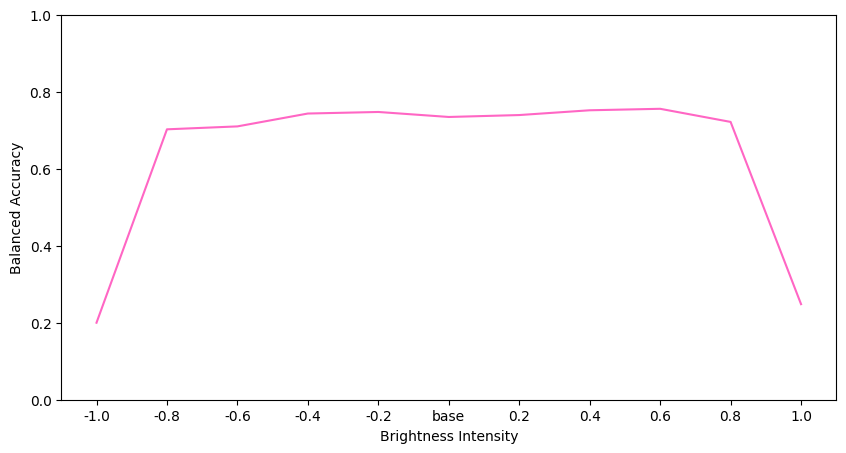

In [11]:
colors = ["#ff66c4"]

plt.figure(figsize=(10, 5))

sns.lineplot(df_agg, y="balanced_accuracies", x="aug_strengths", color=colors[0])

plt.ylabel("Balanced Accuracy", fontsize=10)
plt.xlabel("Brightness Intensity", fontsize=10)

plt.ylim(0.0, 1.0)
# plt.xticks(rotation=45)

plt.show()

In [12]:
df_agg.head(6).iloc[::-1]

,balanced_accuracies,aug_strengths
5,0.734415,base
4,0.747397,-0.2
3,0.743359,-0.4
2,0.709938,-0.6
1,0.702339,-0.8
0,0.200000,-1.0


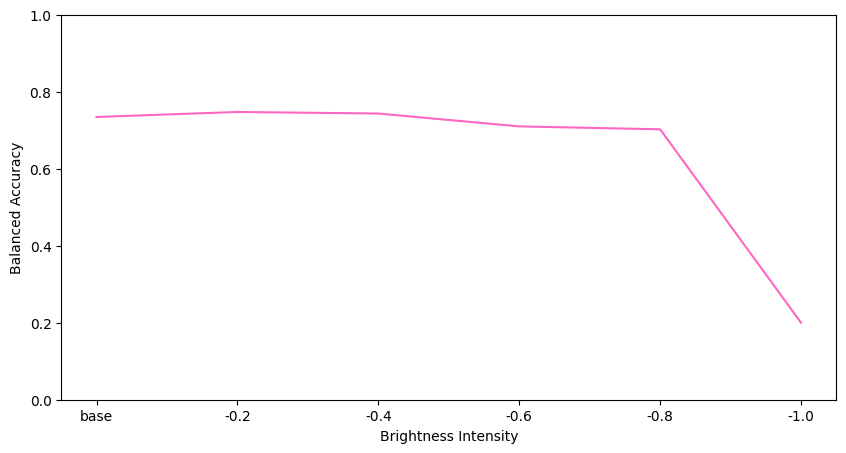

In [13]:
colors = ["#ff66c4"]

plt.figure(figsize=(10, 5))

sns.lineplot(df_agg.head(6).iloc[::-1], y="balanced_accuracies", x="aug_strengths", color=colors[0])

plt.ylabel("Balanced Accuracy", fontsize=10)
plt.xlabel("Brightness Intensity", fontsize=10)

plt.ylim(0.0, 1.0)

plt.show()

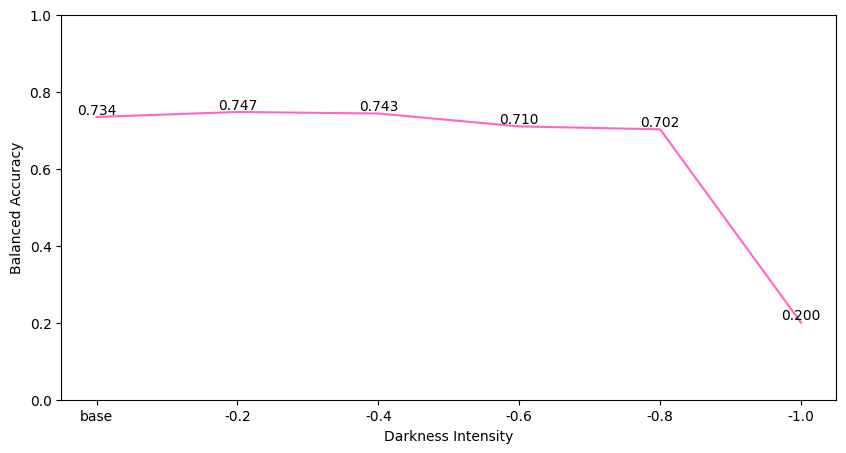

In [14]:
colors = ["#ff66c4"]

plt.figure(figsize=(10, 5))

ax = sns.lineplot(df_agg.head(6).iloc[::-1], y="balanced_accuracies", x="aug_strengths", color=colors[0])

plt.ylabel("Balanced Accuracy", fontsize=10)
plt.xlabel("Darkness Intensity", fontsize=10)

plt.ylim(0.0, 1.0)

for x, y in zip(df_agg.head(6).iloc[::-1]["aug_strengths"], df_agg.head(6).iloc[::-1]["balanced_accuracies"]):
    plt.text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

plt.show()

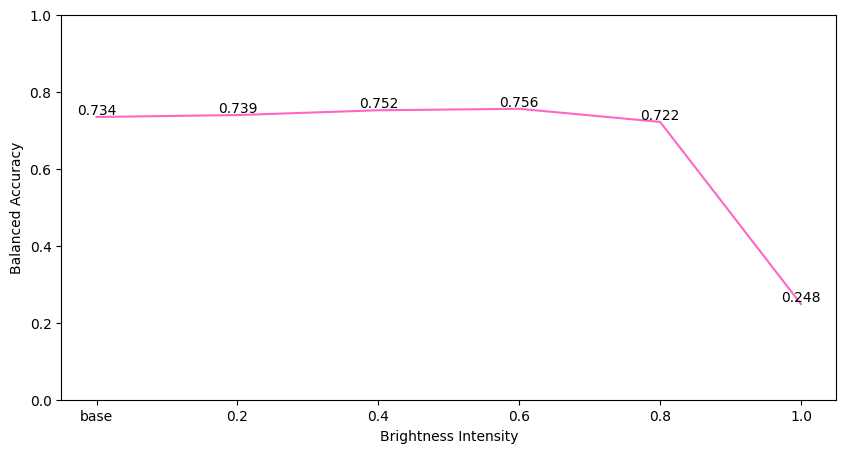

In [15]:
colors = ["#ff66c4"]

plt.figure(figsize=(10, 5))

ax = sns.lineplot(df_agg.tail(6), y="balanced_accuracies", x="aug_strengths", color=colors[0])

plt.ylabel("Balanced Accuracy", fontsize=10)
plt.xlabel("Brightness Intensity", fontsize=10)

plt.ylim(0.0, 1.0)

for x, y in zip(df_agg.tail(6)["aug_strengths"], df_agg.tail(6)["balanced_accuracies"]):
    plt.text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

plt.show()

In [16]:
df_agg.tail(6)

,balanced_accuracies,aug_strengths
5,0.734415,base
6,0.739398,0.2
7,0.751812,0.4
8,0.755655,0.6
9,0.721576,0.8
10,0.248199,1.0


## Per class analysis

In [17]:
def get_filtered_metrics(table_paths, target):
    accuracies = []
    aug_strengths = []

    for table_path in tqdm(table_paths, desc="Extracting Metrics"):
        if np.equal(float(Path(table_path).stem.split("_")[-1]), 0):
            aug_strength = "base"
        
        else:
            aug_strength = float(Path(table_path).stem.split("_")[-1])
        
        df = pd.read_csv(table_path)
        df = df[df["target"] == target]

        accuracy = accuracy_score(df["target"], df["prediction"])
        
        accuracies.append(accuracy)
        aug_strengths.append(aug_strength)

    return accuracies, aug_strengths

## Normal

In [18]:
label = "Normal"

target = label_map[label]

accuracies, aug_strengths = get_filtered_metrics(table_paths, target=target)

results_table = {
    "accuracies": accuracies,
    "aug_strengths": aug_strengths
}

df_agg = pd.DataFrame(results_table)
df_agg["aug_strengths"] = df_agg["aug_strengths"].map(lambda x: str(x))

df_agg.head()

Extracting Metrics:   0%|          | 0/11 [00:00<?, ?it/s]

Extracting Metrics: 100%|██████████| 11/11 [00:00<00:00, 14.61it/s]


,accuracies,aug_strengths
0,1.000000,-1.0
1,0.843970,-0.8
2,0.772948,-0.6
3,0.859507,-0.4
4,0.867518,-0.2


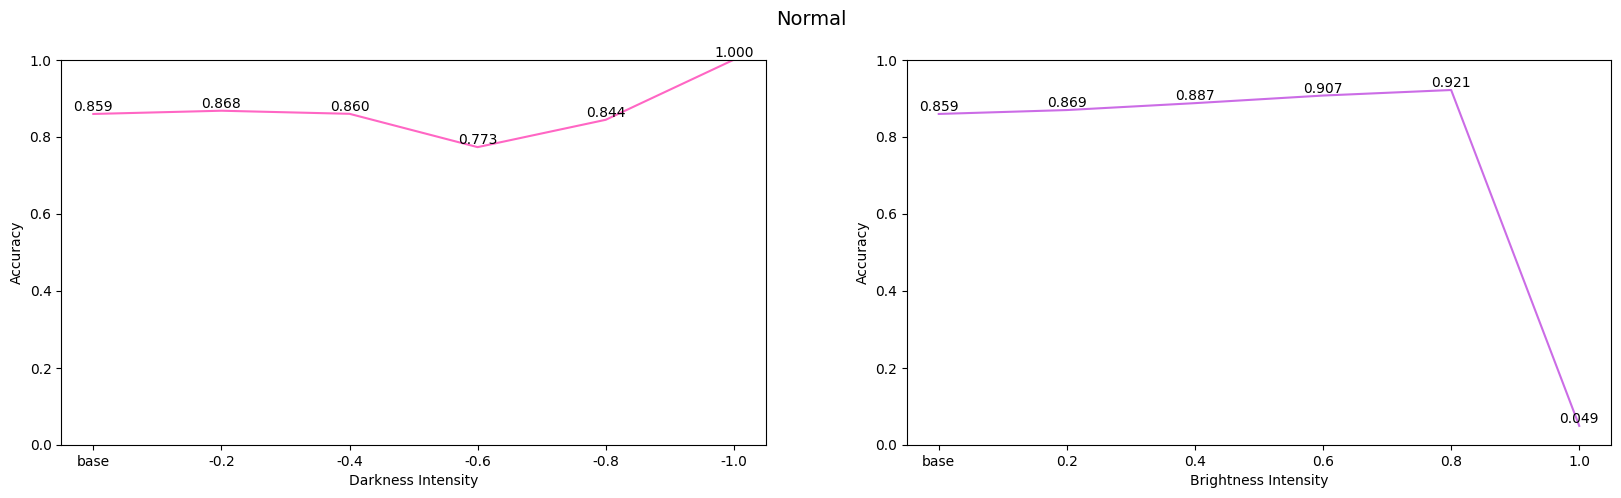

In [19]:
colors = ["#ff66c4", "#cb6ce6"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

fig.suptitle(label, fontsize=14)

# axes 0 - darkness
sns.lineplot(df_agg.head(6).iloc[::-1], y="accuracies", x="aug_strengths", color=colors[0], ax=axes[0])

for x, y in zip(df_agg.head(6).iloc[::-1]["aug_strengths"], df_agg.head(6).iloc[::-1]["accuracies"]):
    axes[0].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[0].set_ylabel("Accuracy", fontsize=10)
axes[0].set_xlabel("Darkness Intensity", fontsize=10)
axes[0].set_ylim(0.0, 1.0)

# axes 1 - brightness
ax = sns.lineplot(df_agg.tail(6), y="accuracies", x="aug_strengths", color=colors[1], ax=axes[1])

for x, y in zip(df_agg.tail(6)["aug_strengths"], df_agg.tail(6)["accuracies"]):
    axes[1].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[1].set_ylabel("Accuracy", fontsize=10)
axes[1].set_xlabel("Brightness Intensity", fontsize=10)
axes[1].set_ylim(0.0, 1.0)

plt.show()

## Stroma

In [20]:
label = "Stroma"

target = label_map[label]

accuracies, aug_strengths = get_filtered_metrics(table_paths, target=target)

results_table = {
    "accuracies": accuracies,
    "aug_strengths": aug_strengths
}

df_agg = pd.DataFrame(results_table)
df_agg["aug_strengths"] = df_agg["aug_strengths"].map(lambda x: str(x))

df_agg.head()

Extracting Metrics: 100%|██████████| 11/11 [00:00<00:00, 15.75it/s]


,accuracies,aug_strengths
0,0.000000,-1.0
1,0.969837,-0.8
2,0.958989,-0.6
3,0.962990,-0.4
4,0.962759,-0.2


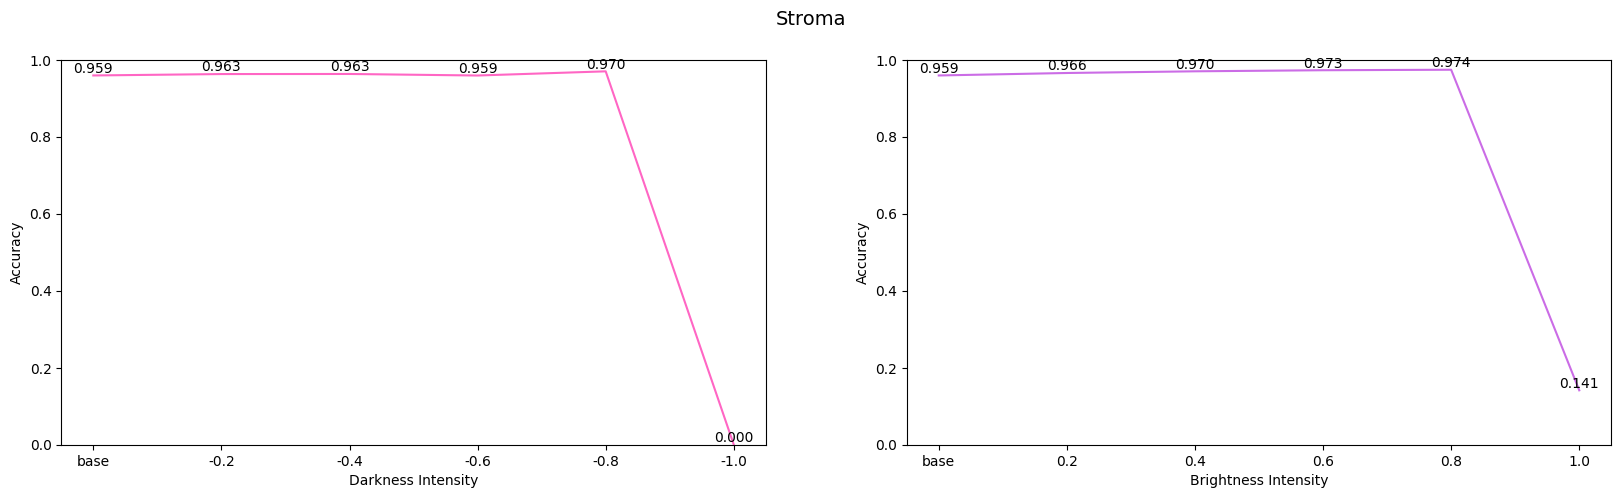

In [21]:
colors = ["#ff66c4", "#cb6ce6"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

fig.suptitle(label, fontsize=14)

# axes 0 - darkness
sns.lineplot(df_agg.head(6).iloc[::-1], y="accuracies", x="aug_strengths", color=colors[0], ax=axes[0])

for x, y in zip(df_agg.head(6).iloc[::-1]["aug_strengths"], df_agg.head(6).iloc[::-1]["accuracies"]):
    axes[0].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[0].set_ylabel("Accuracy", fontsize=10)
axes[0].set_xlabel("Darkness Intensity", fontsize=10)
axes[0].set_ylim(0.0, 1.0)

# axes 1 - brightness
ax = sns.lineplot(df_agg.tail(6), y="accuracies", x="aug_strengths", color=colors[1], ax=axes[1])

for x, y in zip(df_agg.tail(6)["aug_strengths"], df_agg.tail(6)["accuracies"]):
    axes[1].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[1].set_ylabel("Accuracy", fontsize=10)
axes[1].set_xlabel("Brightness Intensity", fontsize=10)
axes[1].set_ylim(0.0, 1.0)

plt.show()

## G3

In [22]:
label = "G3"

target = label_map[label]

accuracies, aug_strengths = get_filtered_metrics(table_paths, target=target)

results_table = {
    "accuracies": accuracies,
    "aug_strengths": aug_strengths
}

df_agg = pd.DataFrame(results_table)
df_agg["aug_strengths"] = df_agg["aug_strengths"].map(lambda x: str(x))

df_agg.head()

Extracting Metrics: 100%|██████████| 11/11 [00:00<00:00, 15.51it/s]


,accuracies,aug_strengths
0,0.000000,-1.0
1,0.821926,-0.8
2,0.828291,-0.6
3,0.779685,-0.4
4,0.777095,-0.2


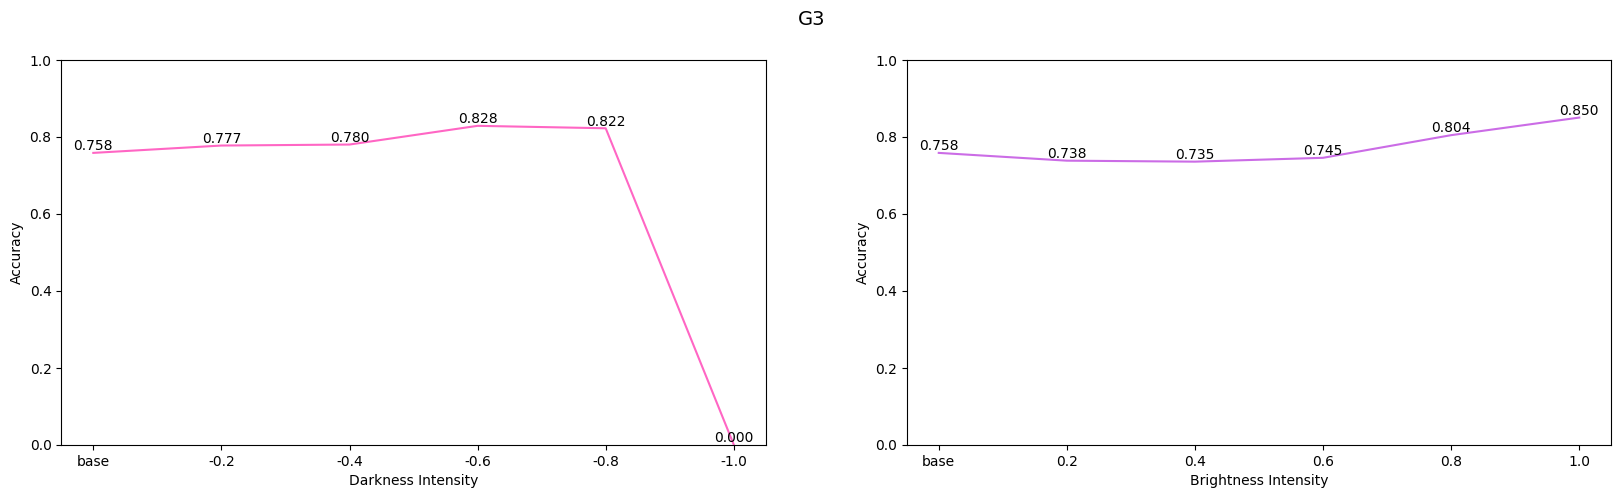

In [23]:
colors = ["#ff66c4", "#cb6ce6"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

fig.suptitle(label, fontsize=14)

# axes 0 - darkness
sns.lineplot(df_agg.head(6).iloc[::-1], y="accuracies", x="aug_strengths", color=colors[0], ax=axes[0])

for x, y in zip(df_agg.head(6).iloc[::-1]["aug_strengths"], df_agg.head(6).iloc[::-1]["accuracies"]):
    axes[0].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[0].set_ylabel("Accuracy", fontsize=10)
axes[0].set_xlabel("Darkness Intensity", fontsize=10)
axes[0].set_ylim(0.0, 1.0)

# axes 1 - brightness
ax = sns.lineplot(df_agg.tail(6), y="accuracies", x="aug_strengths", color=colors[1], ax=axes[1])

for x, y in zip(df_agg.tail(6)["aug_strengths"], df_agg.tail(6)["accuracies"]):
    axes[1].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[1].set_ylabel("Accuracy", fontsize=10)
axes[1].set_xlabel("Brightness Intensity", fontsize=10)
axes[1].set_ylim(0.0, 1.0)

plt.show()

## G4

In [24]:
label = "G4"

target = label_map[label]

accuracies, aug_strengths = get_filtered_metrics(table_paths, target=target)

results_table = {
    "accuracies": accuracies,
    "aug_strengths": aug_strengths
}

df_agg = pd.DataFrame(results_table)
df_agg["aug_strengths"] = df_agg["aug_strengths"].map(lambda x: str(x))

df_agg.head()

Extracting Metrics: 100%|██████████| 11/11 [00:00<00:00, 15.36it/s]


,accuracies,aug_strengths
0,0.000000,-1.0
1,0.848070,-0.8
2,0.852463,-0.6
3,0.847432,-0.4
4,0.842585,-0.2


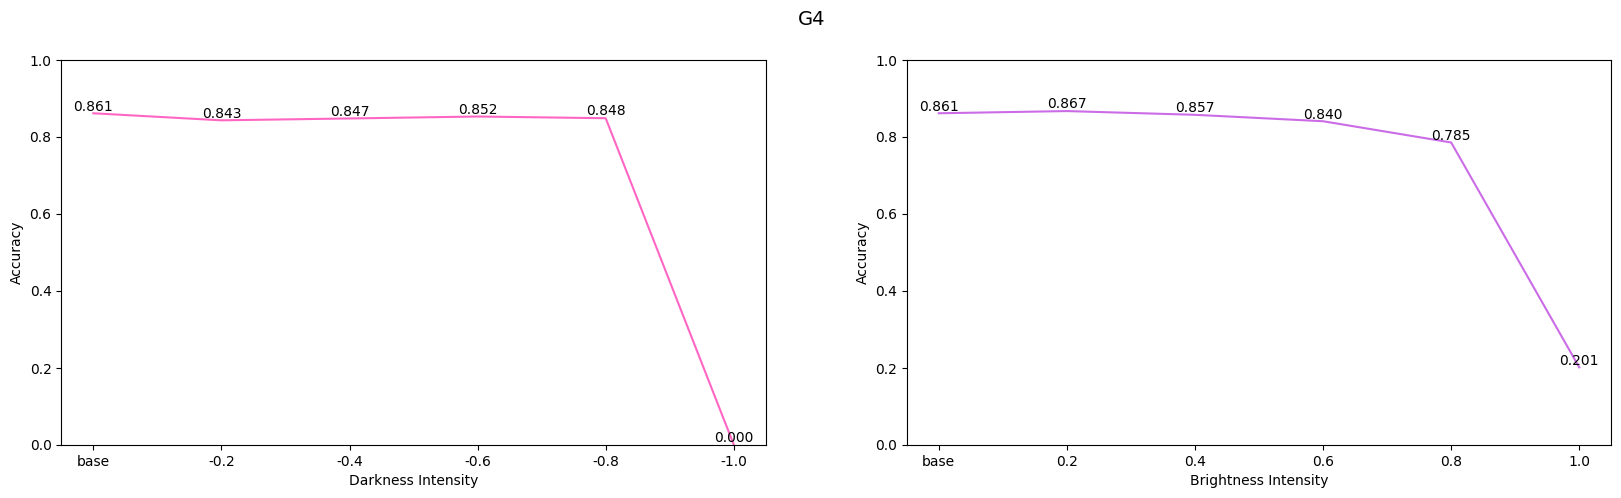

In [25]:
colors = ["#ff66c4", "#cb6ce6"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

fig.suptitle(label, fontsize=14)

# axes 0 - darkness
sns.lineplot(df_agg.head(6).iloc[::-1], y="accuracies", x="aug_strengths", color=colors[0], ax=axes[0])

for x, y in zip(df_agg.head(6).iloc[::-1]["aug_strengths"], df_agg.head(6).iloc[::-1]["accuracies"]):
    axes[0].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[0].set_ylabel("Accuracy", fontsize=10)
axes[0].set_xlabel("Darkness Intensity", fontsize=10)
axes[0].set_ylim(0.0, 1.0)

# axes 1 - brightness
ax = sns.lineplot(df_agg.tail(6), y="accuracies", x="aug_strengths", color=colors[1], ax=axes[1])

for x, y in zip(df_agg.tail(6)["aug_strengths"], df_agg.tail(6)["accuracies"]):
    axes[1].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[1].set_ylabel("Accuracy", fontsize=10)
axes[1].set_xlabel("Brightness Intensity", fontsize=10)
axes[1].set_ylim(0.0, 1.0)

plt.show()

In [26]:
dfs = []

for f in tqdm(table_paths, desc="Processing Tables"):
    df = pd.read_csv(f)
    df["aug_strength"] = [Path(f).stem.split("_")[-1] for _ in range(len(df))]

    dfs.append(df)

concatenated = pd.concat(dfs, axis=0)

Processing Tables: 100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


In [27]:
concatenated.head()

,loss,confidence_score,prediction,target,file_key,aug_strength
0,1.500781,0.222956,0,2,0,-1.0000
1,1.500781,0.222956,0,2,1,-1.0000
2,1.500781,0.222956,0,2,2,-1.0000
3,1.500781,0.222956,0,2,3,-1.0000
4,1.500781,0.222956,0,2,4,-1.0000


In [28]:
label_map_reversed = {v: k for k, v in label_map.items()}

extreme_darkness = concatenated[concatenated["aug_strength"] == "-1.0000"]["prediction"].map(lambda x: label_map_reversed[x]).value_counts()

extreme_darkness.map(lambda x: x / extreme_darkness.sum())

prediction
Normal    1.0
Name: count, dtype: float64

In [29]:
extreme_brightness = concatenated[concatenated["aug_strength"] == "1.0000"]["prediction"].map(lambda x: label_map_reversed[x]).value_counts()

extreme_brightness.map(lambda x: x / extreme_brightness.sum())

prediction
G3        0.740770
G4        0.148424
Stroma    0.062305
Normal    0.048188
G5        0.000313
Name: count, dtype: float64